In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# show all columns
pd.set_option('display.max_columns', None)

from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import scatterplotmatrix, heatmap

In [2]:
import utils

In [3]:
# reload th imports
import importlib
importlib.reload(utils)

<module 'utils' from '/Users/sophiechance/Documents/Cal/Github/foster_care_analysis/utils.py'>

# Import Data

In [4]:
# 2001 codebook
variable_values_2001_df = pd.read_excel('raw_data/DS101 FC2001v5/Data/Metadata & Text Files/FC Variable Values.xlsx') # Used for mapping
variables_2001_df = pd.read_excel('raw_data/DS101 FC2001v5/Data/Metadata & Text Files/FC Variables.xlsx') # Explains what the variables are

In [10]:
var_name = 'IsWaiting'
variables_2001_df[variables_2001_df['VarName'] == var_name]

,VarName,VarLabel,Start,Length,Columns,Type
98,IsWaiting,Child is waiting for adoption,267,1,267,INTEGER1


In [11]:
variable_values_2001_df[variable_values_2001_df['VarName'] == var_name]

,VarName,Value,ValueLabel
230,IsWaiting,0,No
231,IsWaiting,1,Yes


In [7]:
raw_df_2001 = pd.read_sas('raw_data/DS101 FC2001v5/Data/SAS files/fc01v5f.sas7bdat') # Main data file
raw_df_2002 = pd.read_csv('raw_data/DS105 FC2002v8/Data/Text Files/FC2002v8.tab', sep='\t', lineterminator='\n') # Main data file
raw_df_2003 = pd.read_sas('raw_data/DS118 FC2003v7/Data/SAS Files/FC03v7f.sas7bdat') # Main data file

/var/folders/x4/dl28z_rx30n4bp144tvcf38m0000gn/T/ipykernel_95510/3689710240.py:2: DtypeWarning: Columns (7,103) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df_2002 = pd.read_csv('raw_data/DS105 FC2002v8/Data/Text Files/FC2002v8.tab', sep='\t', lineterminator='\n') # Main data file


In [8]:
df_2001 = utils.make_readable(raw_df_2001, variable_values_2001_df)
df_2002 = utils.make_readable(raw_df_2002.rename({'FY':'DataYear', 'FIPSCode':'FIPSCODE'}, axis=1), variable_values_2001_df)
df_2003 = utils.make_readable(raw_df_2003.rename({'FY':'DataYear', 'FIPSCode':'FIPSCODE'}, axis=1), variable_values_2001_df)

# Concatenate Dataframes

In [9]:
# all_records = pd.concat([df_2001, df_2002, df_2003], axis=0)
all_records = df_2001.reset_index() # temporarily doing 2001 only so that the code runs faster
print(all_records.shape)

(813283, 67)


In [32]:
all_records.head()

,index,DataYear,RecNumbr,MR,VISHEAR,PHYDIS,DSMIII,OTHERMED,TOTALREM,NUMPLEP,PHYABUSE,SEXABUSE,NEGLECT,AAPARENT,DAPARENT,AACHILD,DACHILD,CHILDIS,CHBEHPRB,PRTSDIED,PRTSJAIL,NOCOPE,ABANDMNT,RELINQSH,HOUSING,IVEFC,IVEAA,IVAAFDC,IVDCHSUP,XIXMEDCD,SSIOTHER,NOA,FCMntPay,SettingLOS,PreviousLOS,LifeLOS,AgeAtStart,AgeAtLatRem,AgeAtEnd,InAtStart,InAtEnd,Entered,Exited,Served,IsWaiting,IsTPR,AgedOut,State,FIPSCode,Sex,AgeAdopt,removalManner,currentPlacementSetting,OutOfStatePlacement,caseGoal,caretakerFamilyStructure,fosterFamilyStructure,dischargeReason,raceEthnicity,everAdopted,diagnosedDisability,age2021
0,3,2001,5085,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,241.0,3077.0,0.0,6727.0,18.0,1.0,19.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,Alabama,Fewer than 1000 cases in the County,Female,Unknown,Court ordered,"Foster home, relative",No,Long-term foster care,Unable to determine,Not applicable,Emancipation,"NH, Black","No, has never been legally adopted",Not yet determined,40.0
1,6,2001,7376,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,205.0,5527.0,0.0,7054.0,18.0,0.0,19.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,Alabama,Fewer than 1000 cases in the County,Female,Unknown,Court ordered,"Foster home, non-relative",No,Long-term foster care,Married couple,Not applicable,Emancipation,"NH, Black","No, has never been legally adopted",Not yet determined,39.0
2,7,2001,8421,0.0,0.0,0.0,0.0,0.0,1.0,13.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,6788.0,19.0,1.0,19.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,Alabama,Fewer than 1000 cases in the County,Male,Unknown,Court ordered,DNG,No,Long-term foster care,Single female,Not applicable,Emancipation,"NH, Black","No, has never been legally adopted",Not yet determined,41.0
3,14,2001,9877,0.0,0.0,0.0,1.0,1.0,2.0,11.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,241.0,658.0,511.0,6011.0,17.0,2.0,18.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,Alabama,Fewer than 1000 cases in the County,Male,Unknown,Court ordered,"Foster home, non-relative",No,Long-term foster care,Unmarried couple,Not applicable,Living with other relative(s),"Non-Hispanic (NH), White","No, has never been legally adopted",Yes,38.0
4,15,2001,12543,1.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,241.0,5999.0,398.0,6894.0,20.0,3.0,21.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,Alabama,Fewer than 1000 cases in the County,Male,Unknown,Court ordered,"Foster home, non-relative",No,Long-term foster care,Married couple,Married couple,Emancipation,"Non-Hispanic (NH), White","No, has never been legally adopted",Yes,41.0


# Clean up NaN values

In [10]:
# columns_before = set(all_records.columns)
# all_records.dropna(thresh=0.2*len(all_records), axis=1, inplace=True) # Drop columns with more than 20% NaNs
# columns_after = set(all_records.columns)
# print(columns_before - columns_after)
all_records.dropna(thresh=0.5*len(all_records.columns), axis=0, inplace=True) # Drop rows with more than 50% NaNs

print(all_records.shape)

(748224, 67)


In [11]:
# Clean up NaNs
# Payment Columns
all_records['FCMntPay'] = all_records['FCMntPay'].replace(np.nan, 0).astype(float) # Assumed that if null then they are not getting paid
all_records['IVEFC'] = all_records['IVEFC'].replace(np.nan, 0).astype(float) # Assumed that if null then they are not getting paid
all_records['IVAAFDC'] = all_records['IVAAFDC'].replace(np.nan, 0).astype(float) # Assumed that if null then they are not getting paid

# Length of Stay Columns
all_records['PreviousLOS'] = all_records['PreviousLOS'].replace(np.nan, 0).astype(float) # Replace NaNs with 0 because it means they have no previous LOS
all_records['LifeLOS'] = all_records['LifeLOS'].replace(np.nan, 0).astype(float) # Replace NaNs with 0, if this is null, it is their first placement
all_records['SettingLOS'] = all_records['SettingLOS'].replace(np.nan, 0).astype(float) # Replace NaNs with 0 # TODO: Not sure if this is an accurate represnetation, need to look into this more

# Placement
all_records['TOTALREM'] = all_records['TOTALREM'].replace(np.nan, 1).astype(float) # Assume first removal, all records with null have a value of 0 in PreviousLOS
all_records['NUMPLEP'] = all_records['NUMPLEP'].replace(np.nan, 1).astype(float) # Assume 1 placement if null

# Default to no for these columns # TODO - Decide if this is the best way to handle these
nan_to_0_cols = ['VISHEAR', 'PHYDIS', 'MR', 'OTHERMED', 'DSMIII', 'RELINQSH', 'HOUSING', 'PRTSDIED', 'PRTSJAIL', 'CHILDIS', 'DACHILD', 'AACHILD', 'ABANDMNT', 'CHBEHPRB', 'NOCOPE', 'DAPARENT', 'AAPARENT', 'SEXABUSE', 'PHYABUSE', 'IVDCHSUP', 'NOA', 'IVEAA', 'XIXMEDCD', 'IVAAFDC', 'NEGLECT', 'SSIOTHER']
all_records[nan_to_0_cols] = all_records[nan_to_0_cols].fillna(0)

# Replace NaNs with 'DNG' (Data Not Given) for these columns - seperate from Unknown
nan_to_dng_cols = ['currentPlacementSetting', 'dischargeReason', 'fosterFamilyStructure', 'everAdopted', 'caretakerFamilyStructure', 'diagnosedDisability', 'OutOfStatePlacement', 'removalManner', 'caseGoal', 'FIPSCode', 'Sex']
all_records[nan_to_dng_cols] = all_records[nan_to_dng_cols].fillna('DNG')

# Drop any rows where the id did not come in properly # TODO: Investigate why this is happening
print(f"Records with a bad ID: {len(all_records[all_records['RecNumbr'].str.contains('[a-zA-Z]', na=False)])}")
all_records = all_records[~all_records['RecNumbr'].str.contains('[a-zA-Z]', na=False)]

all_records.drop(columns=['secondCaretakerAge', 
                          'secondFosterCaretakerAge', 
                          'firstFosterCaretakerAge',
                          'firstCaretakerAge',
                        #   'RU13\r', # Not needed, Rural Urban Continuum Code, only included in 2002
                        #   'Race', # Not needed, incorperated into other columns (one hot encoding style), only included in 2002
                          'LatRemLOS', # column seems repetitive in nature
                          ], inplace=True)

# Drop records where RecNumbr is unknown
all_records = all_records[all_records['RecNumbr'] == all_records['RecNumbr']] # Drop records where RecNumbr is unknown
print(f"RecNumbr Unknown: {len(all_records[all_records['RecNumbr'] != all_records['RecNumbr']])}")

# Drop records where age is unknown
all_records['AgeAtStart'] = all_records['AgeAtStart'].fillna(99) # some are blank and some are 99, entry error
all_records = all_records[all_records['AgeAtStart'] != 99]
print(f"Age Unknown: {len(all_records[all_records['AgeAtStart'] == 99])}\n")

# Final Stats
print(f"Total Null Values: {all_records.isnull().sum().sum()}")
print(f"Total Records: {len(all_records)}")
print(f"Total Columns: {len(all_records.columns)}")

Records with a bad ID: 268620
RecNumbr Unknown: 0
Age Unknown: 0

Total Null Values: 0
Total Records: 479526
Total Columns: 62


In [12]:
# all_records.isnull().sum().sort_values(ascending=False).head(20)

# Filtering Data
Filter for only records that have 
1. Exited the system
2. Are older than 18 years old in 2021
3. dischargeReason is known

In [12]:
# overwriting all records here to save memory - previously named: included_subset
all_records = all_records[(all_records['Exited'] == 1) & (all_records['age2021'] >= 18) & (all_records['dischargeReason'] != 'DNG')].reset_index(drop=True)
print(f"Total Records: {len(all_records)}")

Total Records: 150732


In [36]:
# all_records.to_csv('cleaned_subset_data.csv', index=False)

# Visualizations

(<Figure size 1000x600 with 9 Axes>,
 array([[<Axes: xlabel='AgeAtStart', ylabel='Count'>, <Axes: >, <Axes: >],
        [<Axes: xlabel='LifeLOS', ylabel='AgeAtStart'>,
         <Axes: xlabel='LifeLOS', ylabel='Count'>, <Axes: >],
        [<Axes: xlabel='FCMntPay', ylabel='AgeAtStart'>,
         <Axes: xlabel='FCMntPay', ylabel='LifeLOS'>,
         <Axes: xlabel='FCMntPay', ylabel='Count'>]], dtype=object))

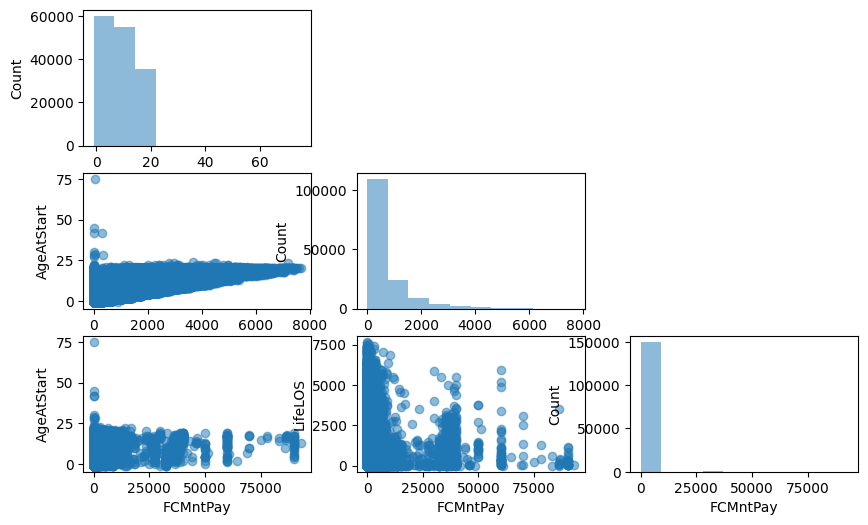

In [13]:
cols = ['AgeAtStart', 'LifeLOS', 'FCMntPay']
scatterplotmatrix(all_records[cols].values, figsize=(10, 6), names=cols, alpha=0.5)

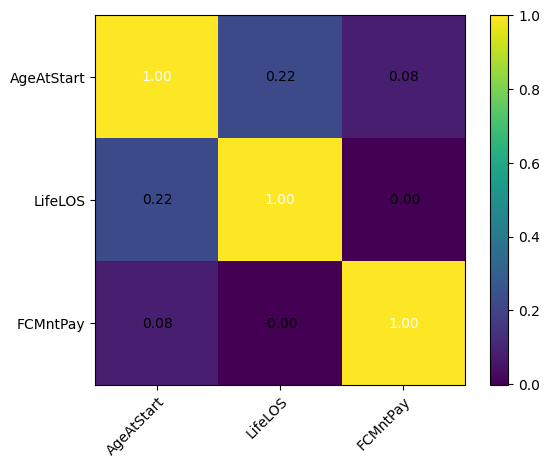

In [14]:
cm = np.corrcoef(all_records[cols].values.T)
hm = heatmap(cm, row_names=cols, column_names=cols)
plt.show()

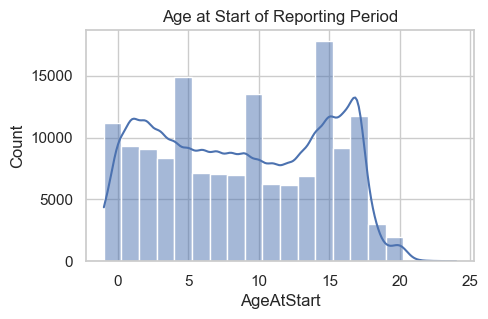

In [15]:
# plot the distribution of the ages
sns.set(style="whitegrid")
plt.figure(figsize=(5, 3))
sns.histplot(all_records['AgeAtStart'].where(all_records['AgeAtStart'] < 26 , np.nan), kde=True, bins=20)
plt.title('Age at Start of Reporting Period')
plt.show()

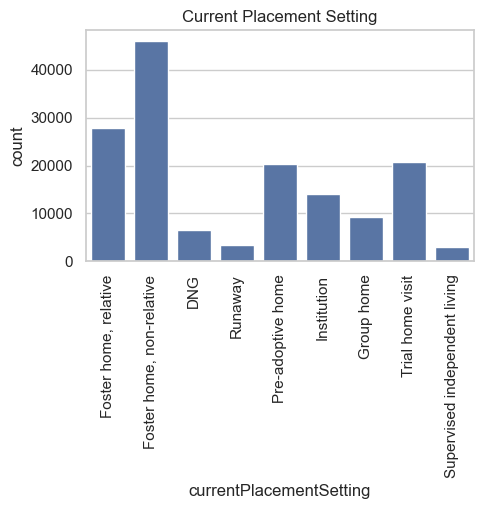

In [17]:
# plot the current placement setting
plt.figure(figsize=(5, 3))
sns.countplot(data=all_records, x='currentPlacementSetting')
plt.title('Current Placement Setting')
plt.xticks(rotation=90)
plt.show()

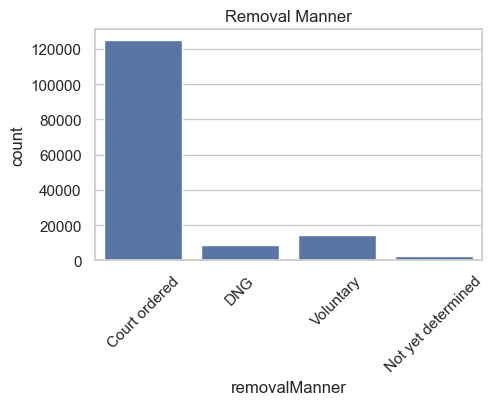

In [18]:
# plot the current placement setting
plt.figure(figsize=(5, 3))
sns.countplot(data=all_records, x='removalManner')
plt.title('Removal Manner')
plt.xticks(rotation=45)
plt.show()

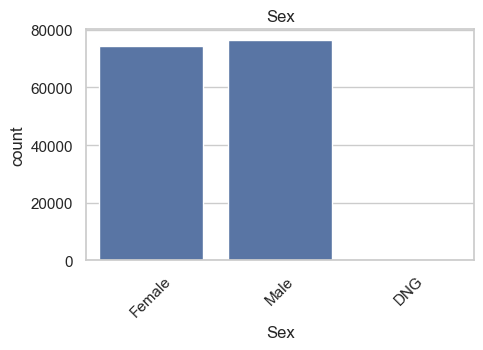

In [19]:
plt.figure(figsize=(5, 3))
sns.countplot(data=all_records, x='Sex')
plt.title('Sex')
plt.xticks(rotation=45)
plt.show()

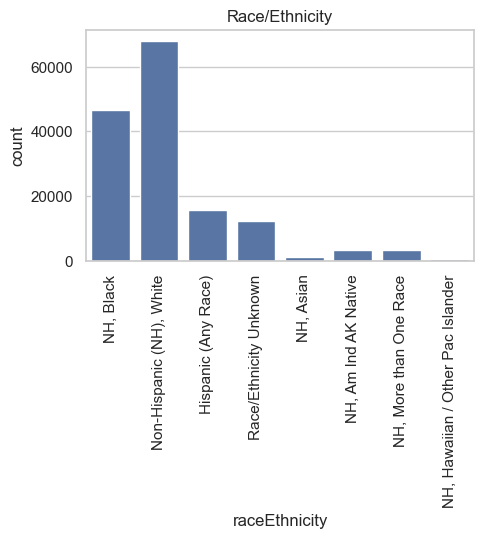

In [29]:
plt.figure(figsize=(5, 3))
sns.countplot(data=all_records, x='raceEthnicity')
plt.title('Race/Ethnicity')
plt.xticks(rotation=90)
plt.show()

In [21]:
all_records.groupby('State')['RecNumbr'].count().sort_values(ascending=False) #.plot(kind='bar', figsize=(5, 3))

State
Florida                 16865
Pennsylvania            12325
Michigan                 8312
Illinois                 8005
Texas                    7191
Georgia                  7119
Massachusetts            5833
Oklahoma                 5800
Missouri                 5702
North Carolina           5237
Tennessee                4985
Colorado                 4942
Arizona                  4729
New Jersey               4597
Indiana                  4570
Wisconsin                4349
Oregon                   4343
Kentucky                 3910
South Carolina           3011
Arkansas                 2908
Maryland                 2872
Nebraska                 2155
Alabama                  2100
Virginia                 2096
Utah                     2004
Hawaii                   1912
New Mexico               1737
Mississippi              1665
West Virginia            1445
Rhode Island             1216
South Dakota             1136
Idaho                    1084
Puerto Rico               970
Wyom

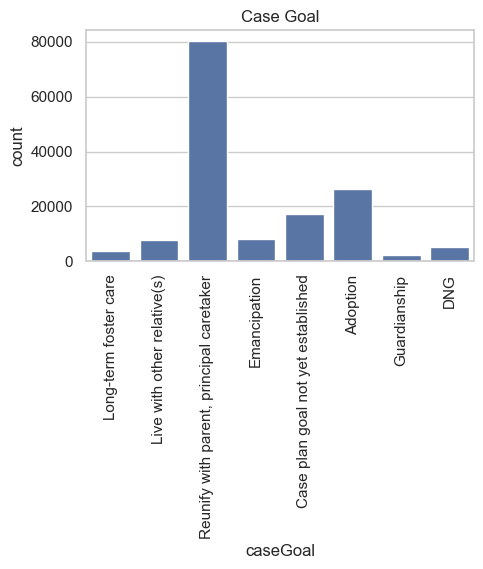

In [30]:
plt.figure(figsize=(5, 3))
sns.countplot(data=all_records, x='caseGoal')
plt.title('Case Goal')
plt.xticks(rotation=90)
plt.show()

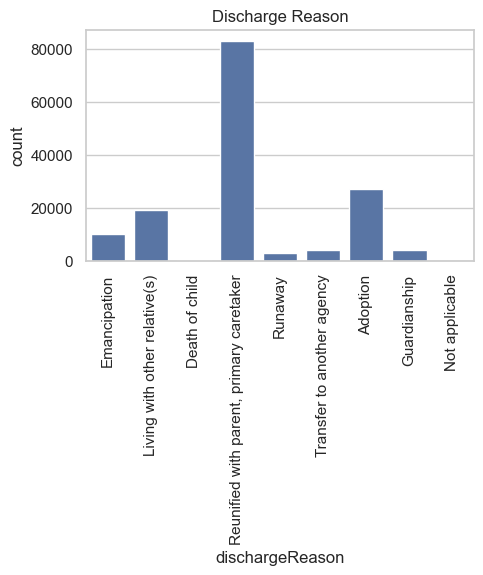

In [31]:
plt.figure(figsize=(5, 3))
sns.countplot(data=all_records[all_records['Exited'] == 1], x='dischargeReason')
plt.title('Discharge Reason')
plt.xticks(rotation=90)
plt.show()

# Defining Success in Foster Care

Intention: Predict the likelihood of a child successfully being reunified with their parent.

- dischargeReason = Reunified with parent, primary caretaker
- Does not enter the system a second time before the age of 18.

#### Entering the System Again
In order to successfully measure this we need to:
1. Calculate the age of each exited ['Exited' = 1] child relative to 2021 (the last year of reporting) and make sure it is at least 18.
2. Check to see if these children appear again in the data set after their exit date.
3. If child never appears again in the data set and their age is above 18 by 2021, they are considered to have successfully exited the system.

### Subquestions
- What is the likelihood of a child who has been reunified with their parent entering the system again?